In [1]:
import sys
import os
import itertools

import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as spopt
import scipy.integrate as spi
import scipy.stats as sps

import tensorflow as tf
import pandas as pd

sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("../")
import util

%matplotlib inline

In [2]:
config = "ns_3_mreg_3_msub_0_nf_32"
conn = "linw"
preproc = "dicer"
modelname = "AB"
isub = 5

ds = ndsv.Dataset.from_file(f"../run/hcp/hcp100_{conn}_{preproc}/dataset.npz")
# run = util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname, config, [0,1], "hcp")
run = 1
direc = f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}"
params = util.load_params(os.path.join(direc, "parameters"), np.r_[:100])
sims = ndsv.GeneratedData.from_file(os.path.join(direc, f"simulations/simulations_{isub:03d}.npz"))

model = util.get_model(modelname, config, ds)
model.load_weights(f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}/fit/model")

2022-08-10 17:45:23.512733: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 17:45:23.515271: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
nsub, nreg, _, nt = ds.y.shape

## Phaseplot

In [4]:
def phaseplot2d(ax, model, c1, c2, x, thetareg, thetasub, u=0., ushared=0., scale=6, color='k'):
    assert c1 != c2
    
    plt.sca(ax)
    fx = ndsv.models.evalf(model, x, thetareg=thetareg, thetasub=thetasub, u=u, ushared=ushared)
        
    if c1 < c2: u, v = fx[:,:,c1].T, fx[:,:,c2].T
    else:       u, v = fx[:,:,c1], fx[:,:,c2]
        
    # plt.quiver(x[c1], x[c2], u, v, scale=scale, color=color)
    plt.streamplot(x[c1], x[c2], u, v, density=1, linewidth=1, arrowsize=1, color=color)
    
    velocity = np.sqrt(u**2 + v**2)
    plt.imshow(velocity, cmap='plasma', extent=[x[c1][0], x[c1][-1], x[c2][0], x[c2][-1]], origin='lower',
               alpha=0.5, zorder=-1, vmin=0, vmax=3)


def plot_phaseplot(ax, model, x, treg, tsub, dims=(0,1), dimnames=(1,2), nquiver=10, color='k', label=None,
                   xlabels=True, ylabels=True):
    
    plt.sca(ax)
    rng = (-2., 2.)
    
    # for i in range(x.shape[0]):
    #     plt.plot(x[i,dims[0]], x[i,dims[1]], color='yellow', alpha=1, lw=0.25, zorder=10)
    
    xq = [0. for _ in range(model.ns)]
    xq[dims[0]] = np.linspace(rng[0], rng[1], nquiver)
    xq[dims[1]] = np.linspace(rng[0], rng[1], nquiver)
    phaseplot2d(ax, model, dims[0], dims[1], x=xq, thetareg=treg, thetasub=tsub,
                u=0., ushared=0., scale=20, color='k')
    plt.xlim(rng); plt.ylim(rng)
    
    plt.xticks([-2,0,2], None if xlabels else ["","",""])
    if xlabels: plt.xlabel(f"$x_{dimnames[0]}$", labelpad=0)
        
    plt.yticks([-2,0,2], None if ylabels else ["","",""])
    if ylabels: plt.ylabel(f"$x_{dimnames[1]}$", labelpad=0)
    
    if label:
        plt.text(0.04, 0.96, label, ha='left', va='top', transform=ax.transAxes, color=color, fontsize=8, 
                 bbox=dict(boxstyle='square', facecolor='white', alpha=0.85))
        
    
    for pos in ['bottom', 'top', 'right', 'left']:
        ax.spines[pos].set_color(color)
        ax.spines[pos].set_linewidth(1.5)
    ax.tick_params(axis='both', colors=color)
    ax.xaxis.label.set_color(color)
    ax.yaxis.label.set_color(color)

In [5]:
def init_points(method, n, init_range, ns):
    if method == 'grid':
        x0 = np.array(np.meshgrid(*(ns * [np.linspace(init_range[0], init_range[1], n)]))).reshape((ns, -1)).T
    elif method == 'random':
        x0 = np.random.uniform(init_range[0], init_range[1], size=(n, ns))
    return x0


def deduplicate(xs, threshold):
    xds = []    
    for x in xs:  
        if np.any([(np.linalg.norm(x - xd) < threshold) for xd in xds]):
            continue
        else:
            xds.append(x)            
    return np.array(xds)


def find_fixed_points(model, thetareg, thetasub, u=None, us=None, init='grid', n=5, init_range=(-2,2),
                      threshold=1e-4):
    
    assert len(thetareg) == model.mreg
    assert len(thetasub) == model.msub
    if model.source_model.network_input: assert u  is not None
    if model.source_model.shared_input:  assert us is not None
    
    x0 = init_points(init, n, init_range, model.ns)
    n_ = len(x0)

    fixed_input = [thetareg, thetasub]
    if model.source_model.network_input: fixed_input.append([u])
    if model.source_model.shared_input:  fixed_input.append([us])
    fixed_input = np.concatenate(fixed_input)

    input_size = (model.ns + model.mreg + model.msub
                  + int(model.source_model.network_input) + int(model.source_model.shared_input))
    xaug = np.zeros((input_size))
    xaug[model.ns:] = fixed_input
    
    def f(x):
        xaug_ = np.copy(xaug)
        xaug_[:model.ns] = x
        fx = model.source_model.f(xaug_[None,:])[0].numpy()
        return fx
    
    @tf.function
    def jacobian(x):        
        with tf.GradientTape(persistent=True, watch_accessed_variables=False) as g:
            g.watch(x)
            xaug_ = tf.concat([x, xaug[model.ns:]], axis=0)
            fx = model.source_model.f(xaug_[None,:])[0]            
        jac = g.jacobian(fx, x)
        return jac

    xs = []
    fails = 0
    for i in range(n_):
        sol = spopt.root(f, x0[i], jac=jacobian, method='hybr', tol=1e-6)

        if not sol.success:
            fails += 1
        else:
            xs.append(sol.x)
           
    xs = np.array(xs)
    xs = deduplicate(xs, threshold)
    
    # Evaluate stability
    stability = np.zeros(len(xs), dtype=bool)
    eigvals = np.zeros((len(xs), model.ns), dtype=complex)
    
    for i, x in enumerate(xs):
        jac = jacobian(x).numpy()
        eigvals[i] = np.linalg.eigvals(jac)
        stability[i] = np.all(np.real(eigvals[i]) < 0.)
    
    return xs, stability, eigvals

In [6]:
def is_converging(x, t, nsteps, threshold):
    nsteps = min(len(t), nsteps)
    dist = np.linalg.norm(x[:,:,-nsteps:] - x[:,:,[-1]], axis=1)
    converging = np.zeros(x.shape[0], dtype=bool)
    
    for i in range(x.shape[0]):
        if np.all(dist[i] < threshold):
            converging[i] = True
        else:
            last_above = np.where(dist[i] >= threshold)[0][-1]
            dist_above = dist[i,:last_above+1]
            converging[i] = np.all(dist_above[:-1] > dist_above[1:])
            
    return converging
    
    
def is_periodic(x, t, threshold, min_period=0.):
    n = len(t)
    max_offset = int(len(t) / 4)
    
    diff = np.zeros((max_offset, n-max_offset))
    for i in range(n-max_offset):
        diff[:,i] = np.linalg.norm(x[:,[i]] - x[:,i:i+max_offset], axis=0)
    
    min_ind = np.argwhere(t > t[0] + min_period)[0][0]
    candidate_ind = np.where(np.max(diff[min_ind:,:], axis=1) < threshold)[0][0] + min_ind
    
    if np.max(diff[candidate_ind,:]) < threshold:
        return True, t[candidate_ind] - t[0]
    else:
        return False, np.nan


def find_attractors(model, thetareg, thetasub, u=None, us=None, init='grid', n=5, init_range=(-2,2),
                    T1=100, T2=100):
    assert len(thetareg) == model.mreg
    assert len(thetasub) == model.msub
    if model.source_model.network_input: assert u  is not None
    if model.source_model.shared_input:  assert us is not None
    
    x0 = init_points(init, n, init_range, model.ns)
    n_ = len(x0)
    
    fixed_input = [thetareg, thetasub]
    if model.source_model.network_input: fixed_input.append([u])
    if model.source_model.shared_input:  fixed_input.append([us])
    fixed_input = np.concatenate(fixed_input)

    input_size = (model.ns + model.mreg + model.msub
                  + int(model.source_model.network_input) + int(model.source_model.shared_input))
    xaug = np.zeros((n_, input_size))
    xaug[:, model.ns:] = fixed_input
    
    def f(t, x):
        xaug_ = np.copy(xaug)
        xaug_[:, :model.ns] = np.reshape(x, (n_, model.ns))
        fx = model.source_model.f(xaug_[None,:])[0].numpy()
        return np.reshape(fx, (n_ * model.ns))
        
    x0 = np.reshape(x0, (model.ns * n_))

    # Simulate all 
    sol = spi.solve_ivp(f, (0, T1), x0, method='RK45', max_step=1)
    if not sol.success:
        raise ValueError(message)
    
    x = np.reshape(sol.y, (n_, model.ns, -1))
    t = sol.t
    converging = is_converging(x, t, int(0.1*len(t)), 1e-3)
    
    # Simulate the non-converging
    periodic = np.zeros_like(converging, dtype=bool)
    period = np.full(len(periodic), np.nan)
    
    if np.any(~converging):
        sol2 = spi.solve_ivp(f, (0, T2), x0, method='RK45', max_step=0.5)
            
        if not sol2.success:
            raise ValueError(message)
    
        x = np.reshape(sol2.y, (n_, model.ns, -1))
        t = sol2.t
            
        mask = t > T1
        for i in range(n_):
            if not converging[i]:
                periodic[i], period[i] = is_periodic(x[i,:][:,mask], t[mask], 0.1, min_period=2.)
    
    return (t, x, converging, periodic, period)

In [7]:
# for dims in [(0, 1), (0, 2), (1, 2)]:
#     plt.figure(figsize=(5,5), dpi=100)
#     plot_phaseplot(plt.gca(), model, sims.x[[0],0,ireg,:,-nt//2:-nt//4],
#                    treg=treg, tsub=tsub,
#                    dims=dims, dimnames=dims, nquiver=100,
#                    color='b',
#                    label="", xlabels=True)

#     plt.scatter(fixed_points[stability,0],  fixed_points[stability,1],  color='k', ec='k', s=140, lw=2, zorder=20)
#     plt.scatter(fixed_points[~stability,0], fixed_points[~stability,1], color='w', ec='k', s=140, lw=2, zorder=20)

#     for i in range(len(periodic)):
#         if periodic[i]:
#             mask = (t > t[-1]/2.) * (t <= t[-1]/2. + period[i])
#             plt.plot(x[i,0,mask], x[i,1,mask], color='k', ls='--', lw=3)
#         break

## Sweep the subjects!

u std: 0.7694911955495518
us std: 1.0096315841866432


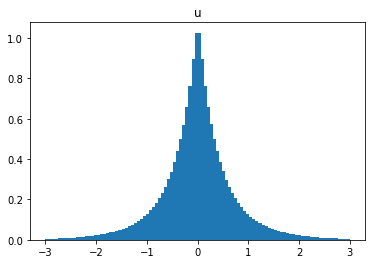

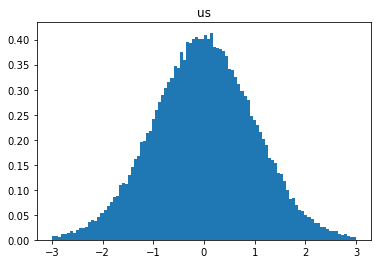

In [8]:
# What is the right parameter range for u and us?

def get_network_input_obs(w, y, comp=0):
    """
    Calculate the network input, using the comp component of the observations
    """

    nsub, nreg, nobs, nt = y.shape
    assert w.shape == (nsub, nreg, nreg)

    yinp = np.zeros((nsub, nreg, 1, nt))
    for i in range(nsub):
        for j in range(nreg):
            yinp[i, j, 0, :] = np.dot(w[i,j,:], y[i, :, comp, :])

    return yinp


u = get_network_input_obs(ds.w, ds.y, comp=0)

plt.figure()
plt.title("u")
plt.hist(u.ravel(), bins=np.linspace(-3,3,101), density=True);
print(f"u std: {np.std(u.ravel())}")

us = np.random.normal(params.us[:,:,0], params.us[:,:,1])
plt.figure()
plt.title("us")
plt.hist(us.ravel(), bins=np.linspace(-3,3,101), density=True);
print(f"us std: {np.std(us.ravel())}")

In [9]:
rows_fp = []
rows_at = []

iconf = 0

for isub in range(0,10):
    print(f"Subject {isub}: ", end='', flush=True)
    
    for ireg in range(0,68):
        print(f"{ireg} ", end='', flush=True)
        
        treg = np.random.normal(params.thetareg[isub,ireg,:,0], params.thetareg[isub,ireg,:,1])
        tsub = np.zeros(1)
        
        for u, us in itertools.product([-1, 0, 1], [-1, 0, 1]):
            fixed_points, stability, eigvals = find_fixed_points(model, treg, tsub, u=u, us=us,
                                                                 init='random', n=60, init_range=(-2,2))
            
            t, x, converging, periodic, period = find_attractors(model, treg, tsub, u=u, us=us,
                                                                 init='random', n=60, init_range=(-2,2),
                                                                 T1=400, T2=1200)

            for fp, stab, evs in zip(fixed_points, stability, eigvals):
                rows_fp.append(dict(iconf=iconf, isub=isub, ireg=ireg,
                                    treg0=treg[0], treg1=treg[1], treg2=treg[2], u=u, us=us,
                                    stable=stab,
                                    x0=fp[0], x1=fp[1], x2=fp[2],
                                    ev0=evs[0], ev1=evs[1], ev2=evs[2]))
                
            rows_at.append(dict(iconf=iconf, isub=isub, ireg=ireg, 
                                treg0=treg[0], treg1=treg[1], treg2=treg[2], u=u, us=us,
                                has_converging=np.any(converging),
                                has_nonconverging=np.any(~converging),
                                has_periodic=np.any(periodic[~converging]),
                                has_aperiodic=np.any(~periodic[~converging]),
                               ))
            
            iconf += 1

    print("")
            
df_fp = pd.DataFrame(rows_fp)
df_at = pd.DataFrame(rows_at)

df_fp.to_csv("res/df_fp.csv")
df_at.to_csv("res/df_at.csv")

Subject 0: 0 

2022-08-10 17:46:30.358996: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 
Subject 1: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 
Subject 2: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 
Subject 3: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 
Subject 4: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62

## Fixed points

In [10]:
df = df_fp

In [11]:
df

,iconf,isub,ireg,treg0,treg1,treg2,u,us,stable,x0,x1,x2,ev0,ev1,ev2
0,0,0,0,0.588241,0.254225,-0.302662,-1,-1,True,-0.002401,0.351743,0.085384,-1.000937+0.000000j,-0.520662+0.000000j,-1.331566+0.000000j
1,1,0,0,0.588241,0.254225,-0.302662,-1,0,True,-0.002159,0.179024,0.043109,-1.000933+0.000000j,-1.281644+0.000000j,-0.495989+0.000000j
2,2,0,0,0.588241,0.254225,-0.302662,-1,1,True,-0.001928,0.010448,0.001241,-1.000933+0.000000j,-1.281644+0.000000j,-0.495989+0.000000j
3,3,0,0,0.588241,0.254225,-0.302662,0,-1,True,-0.001334,0.124170,0.039195,-1.000940+0.000000j,-0.555852+0.000000j,-1.320716+0.000000j
4,4,0,0,0.588241,0.254225,-0.302662,0,0,True,-0.001104,-0.038139,-0.001034,-1.000937+0.000000j,-1.271563+0.000000j,-0.530409+0.000000j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6115,6115,9,67,0.249566,0.908908,-1.037298,0,0,True,-0.001821,0.000927,0.003228,-1.000925+0.000000j,-1.246305+0.000000j,-0.578350+0.000000j
6116,6116,9,67,0.249566,0.908908,-1.037298,0,1,True,-0.001309,-0.282298,-0.047901,-1.000933+0.000000j,-0.540328+0.000000j,-1.244630+0.000000j
6117,6117,9,67,0.249566,0.908908,-1.037298,1,-1,True,-0.001294,0.115918,0.021817,-1.000916+0.000000j,-1.257276+0.000000j,-0.491258+0.000000j
6118,6118,9,67,0.249566,0.908908,-1.037298,1,0,True,-0.000842,-0.130664,-0.026492,-1.000916+0.000000j,-1.253743+0.000000j,-0.539528+0.000000j


In [12]:
# Multiple fixed points?

dff = pd.concat(g for _, g in df.groupby("iconf") if len(g) > 1)

print(" iconf   #fp    distance")
for iconf in dff.iconf.unique():
    dfff = dff[dff.iconf == iconf]
    nfp = len(dfff)
    x = dfff[['x0', 'x1', 'x2']].to_numpy()
    dist = np.max(np.linalg.norm(x[None,:,:] - x[:,None,:], axis=2))
    print(f"{iconf:6d}     {nfp}    {dist:8.5f}")

ValueError: No objects to concatenate

LinregressResult(slope=-5.601136154803136, intercept=-2.2646057574527325, rvalue=-0.9090441834786525, pvalue=0.0, stderr=0.032825369965588956, intercept_stderr=0.014471529568526719)

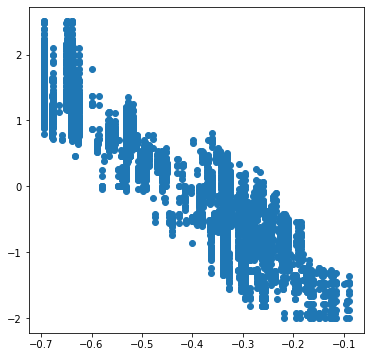

In [13]:
maxre = np.max(np.real(df[['ev0', 'ev1', 'ev2']].to_numpy()), axis=1)

plt.figure(figsize=(6,6))
plt.scatter(maxre, df.treg0)

sps.linregress(maxre, df.treg0)

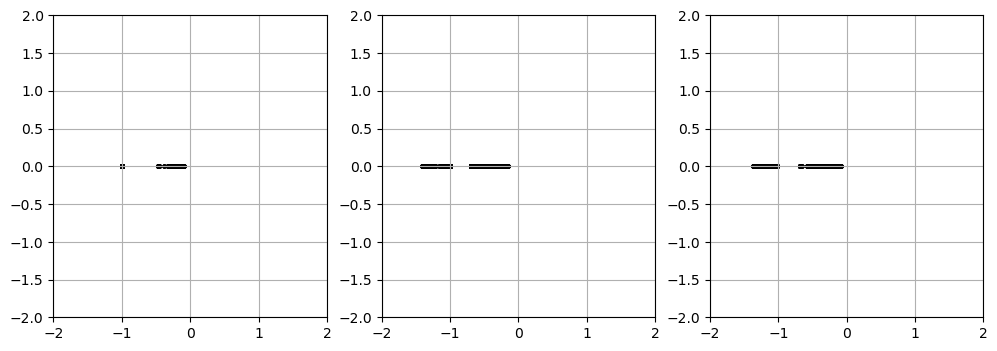

In [14]:
plt.figure(figsize=(12,4), dpi=100)

for i, ev in enumerate(['ev0', 'ev1', 'ev2']):
    plt.subplot(1, 3, i+1)
    
    plt.scatter(np.real(df[ev]), np.imag(df[ev]), s=5, color='k')
    plt.grid()
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

## Attractors

In [15]:
df_at

,iconf,isub,ireg,treg0,treg1,treg2,u,us,has_converging,has_nonconverging,has_periodic,has_aperiodic
0,0,0,0,0.588241,0.254225,-0.302662,-1,-1,True,False,False,False
1,1,0,0,0.588241,0.254225,-0.302662,-1,0,True,False,False,False
2,2,0,0,0.588241,0.254225,-0.302662,-1,1,True,False,False,False
3,3,0,0,0.588241,0.254225,-0.302662,0,-1,True,False,False,False
4,4,0,0,0.588241,0.254225,-0.302662,0,0,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
6115,6115,9,67,0.249566,0.908908,-1.037298,0,0,True,False,False,False
6116,6116,9,67,0.249566,0.908908,-1.037298,0,1,True,False,False,False
6117,6117,9,67,0.249566,0.908908,-1.037298,1,-1,True,False,False,False
6118,6118,9,67,0.249566,0.908908,-1.037298,1,0,True,False,False,False


In [16]:
df = df_at
n = len(df)

print(f"Has converging:    {df.has_converging.sum():5d} / {n}")
print(f"Has nonconverging: {df.has_nonconverging.sum():5d} / {n}")
print(f"Has periodic:      {df.has_periodic.sum():5d} / {n}")
print(f"Has aperiodic:     {df.has_aperiodic.sum():5d} / {n}")

Has converging:     6120 / 6120
Has nonconverging:     0 / 6120
Has periodic:          0 / 6120
Has aperiodic:         0 / 6120
